# Annotation visualizations
Visualizations for the inter-annotator agreement on the gold standard annotation

## Entity IAA
This will be slightly a pain in the ass to read since it's a Markdown file, but here we go

In [17]:
import pandas as pd 
from io import StringIO
import matplotlib.pyplot as plt
%matplotlib inline

In [18]:
def read_entity_iaa(ent_iaa_path):
    """
    Read in the IAA from a bratiaa markdown file.
    
    parameters:
        ent_iaa_path, str: path to Markdown file 
        
    returns:
        dfs, dict: keys are IAA type names, values are df's with IAA values 
        overalls, dict: keys are overall names, values are 2-tuples of (mean, sd)
    """
    per_doc_inst_table = []
    per_label_inst_table = []
    overall_inst = ()
    per_doc_tok_table = []
    per_label_tok_table = []
    overall_tok = ()
    
    tok_inst_counter = 0   # 0: none
                           # 1: in instance-based 
                           # 2: in token-based
    doc_label_counter = 0  # 0: reading irrelevant lines 
                           # 1: reading per-doc 
                           # 2: reading per-label
                
    # Read info for tables 
    with open(ent_iaa_path) as myfile:
        lines = myfile.readlines()
        for line in lines:
            # Check which section we're in 
            if 'Instance-based' in line:
                tok_inst_counter = 1
            elif 'Token-based' in line:
                tok_inst_counter = 2
            
            # Check which subsection we're in
            if 'Agreement per Document' in line:
                doc_label_counter = 1
            elif 'Agreement per Label' in line:
                doc_label_counter = 2
                
            # Check if this is a line to read 
            if line[0] == '|':
                # Put it in the proper table list 
                if tok_inst_counter == 1 and doc_label_counter == 1:
                    per_doc_inst_table.append(line)
                elif tok_inst_counter == 1 and doc_label_counter == 2:
                    per_label_inst_table.append(line)
                elif tok_inst_counter == 2 and doc_label_counter == 1:
                    per_doc_tok_table.append(line)
                elif tok_inst_counter == 2 and doc_label_counter == 2:
                    per_label_tok_table.append(line)
            elif '* Mean F1:' in line:
                first_colon = line.index(':')
                second_colon = line.index(':', first_colon+1)
                first_comma = line.index(',', first_colon+1)
                mean = float(line[first_colon+1:first_comma].strip())
                sd = float(line[second_colon+1:].strip())
                if tok_inst_counter == 1:
                    overall_inst = (mean, sd)
                elif tok_inst_counter == 2:
                    overall_tok = (mean, sd)
                    
    # Convert markdown tables to pandas df 
    tables = {'inst_doc':per_doc_inst_table, 'inst_label':per_label_inst_table,
             'tok_doc':per_doc_tok_table, 'tok_label':per_label_tok_table}
    dfs = {}
    for table_name, table_contents in tables.items():
        # Convert string to readable object
        DATA = StringIO("\n".join(table_contents))
        # Read into pandas df 
        df = pd.read_csv(DATA, sep="|", index_col=1, header=0)
        # Drop the NA columns caused by the pipe chars on either side of the table
        df = df.dropna(axis=1, how='all')
        # Strip whitespace from column and index names 
        df.columns = df.columns.str.strip()
        df.index = df.index.str.strip()
        # Drop the underline row 
        df = df[df['Mean F1'].str.contains("-")==False]
        # Drop rows with 'nan'
        df = df[df['Mean F1'].str.contains('nan')==False]
        # Convert str to int 
        df['Mean F1'] = pd.to_numeric(df['Mean F1'], downcast='float', errors='ignore')
        df['SD F1'] = pd.to_numeric(df['SD F1'], downcast='float', errors='ignore')
        # Add to dict
        dfs[table_name] = df
            
    # Make dict for overall values 
    overalls = {'inst':overall_inst, 'tok':overall_tok}
    
    return dfs, overalls
                    

In [19]:
first_ten_dfs, first_ten_overalls = read_entity_iaa('../data/straying_off_topic_data/iaa/ten_gold_standard_docs.md')

In [20]:
second_ten_dfs, second_ten_overalls = read_entity_iaa('../data/straying_off_topic_data/iaa/second_ten_gold_standard_docs.md')

In [21]:
def entity_iaa_plot(dfs, overalls, type_key, data_title):
    """
    Make a figure with two subplots, one for label and one for document IAA.
    
    parameters:
        dfs, dict: keys are df names, values are dfs with IAA values 
        overalls, dict: keys are names, values are 2-tuples of (mean, sd)
        type_key, str: "inst" or "tok", to indicate which type of IAA is being plotted 
        data_title, str: name for the plot (should describe what the dataset was)
    """
    # Separate out the dataframes to plot 
    doc_df = None
    label_df = None
    for df_name in dfs.keys():
        if type_key in df_name:
            if 'doc' in df_name:
                doc_df = dfs[df_name]
            else: label_df = dfs[df_name]
    
    # Separate out the overall values to use in subtitle            
    overall = overalls[type_key]
    
    # Define titles
    if type_key == 'inst':
        title = f'Entity IAA per instance for {data_title}'
        subtitle = f'Overall IAA: Mean = {overalls["inst"][0]}, SD = {overalls["inst"][1]}'
    else:
        title = f'Entity IAA per token for {data_title}'
        subtitle = f'Overall IAA: Mean = {overalls["tok"][0]}, SD = {overalls["tok"][1]}'
    
    # Make plot 
    fig, ax = plt.subplots(1, 2, figsize=(10, 6), sharey=True)
    
    plt.suptitle(f'{title}\n{subtitle}', fontsize=20, y=1)
    
    ax[0].scatter(x=doc_df.index.tolist(), y=doc_df['Mean F1'])
    ax[0].errorbar(doc_df.index.tolist(), doc_df['Mean F1'], yerr=doc_df['SD F1'], fmt="o")
    for tick in ax[0].get_xticklabels():
        tick.set_rotation(90)
    ax[0].set_xlabel('Document name', fontsize=12)
    ax[0].set_ylabel('F1 across all annotators', fontsize=12)
    ax[0].axhline(y=1.0, color='r', linestyle='dashed')
    ax[0].axhline(y=0.6, color='m', linestyle='dashdot')

    ax[1].scatter(x=label_df.index.tolist(), y = label_df['Mean F1'])
    ax[1].errorbar(label_df.index.tolist(), label_df['Mean F1'], yerr=label_df['SD F1'], fmt="o")
    for tick in ax[1].get_xticklabels():
        tick.set_rotation(90)
    ax[1].set_xlabel('Entity Label', fontsize=12)
    ax[1].axhline(y=1.0, color='r', linestyle='dashed')
    ax[1].axhline(y=0.6, color='m', linestyle='dashdot')


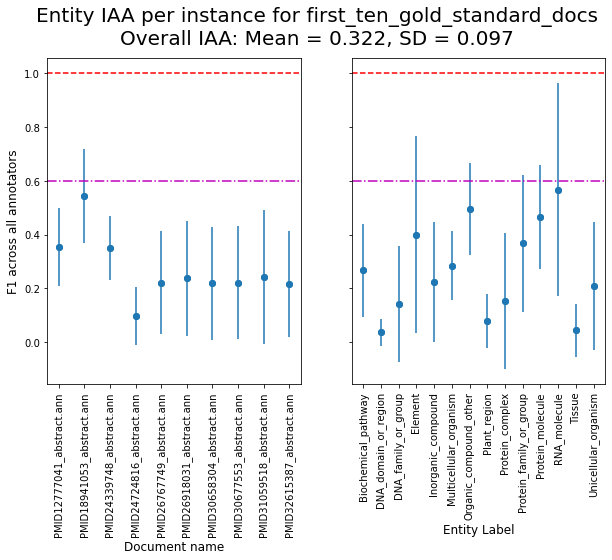

In [22]:
entity_iaa_plot(first_ten_dfs, first_ten_overalls, 'inst', 'first_ten_gold_standard_docs')

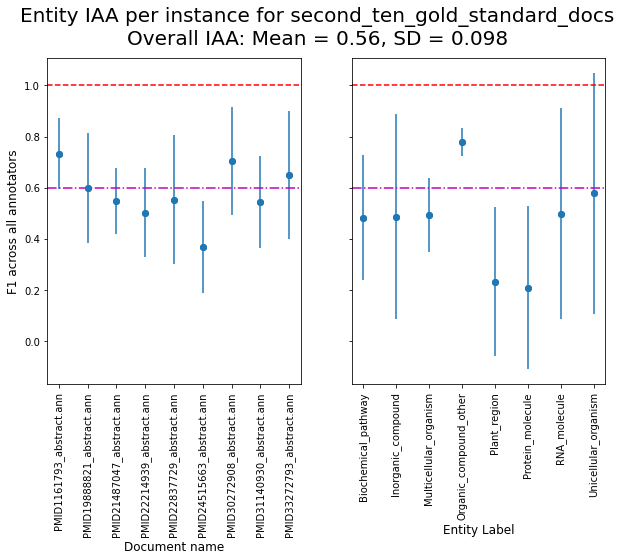

In [23]:
entity_iaa_plot(second_ten_dfs, second_ten_overalls, 'inst', 'second_ten_gold_standard_docs')

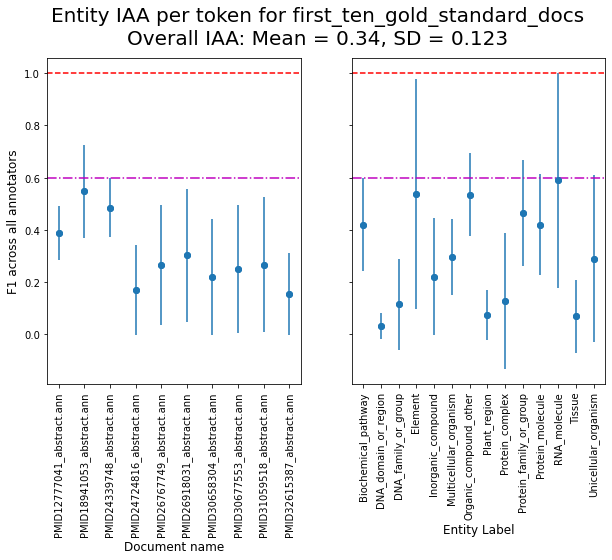

In [24]:
entity_iaa_plot(first_ten_dfs, first_ten_overalls, 'tok', 'first_ten_gold_standard_docs')

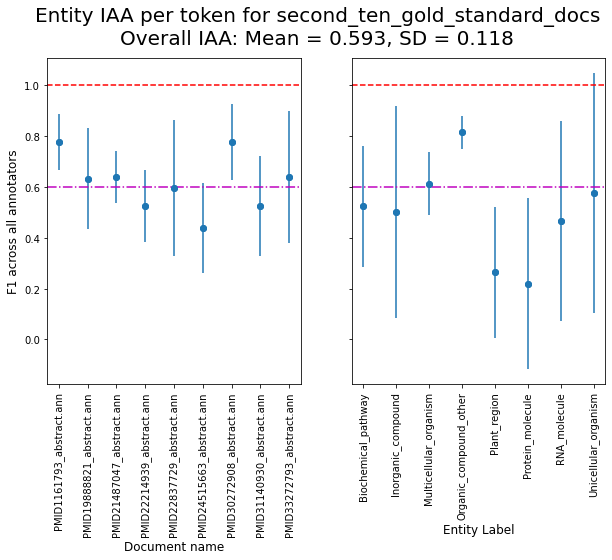

In [25]:
entity_iaa_plot(second_ten_dfs, second_ten_overalls, 'tok', 'second_ten_gold_standard_docs')

## Relation IAA 
I updated `relationIAA.py` to just write the info out as dataframes to simplify this 

In [26]:
def read_relation_iaa(path, prefix):
    """
    Read in the relation IAA data. 
    
    parameters:
        path, str: path to directory containing relation IAA files 
        prefix, str: the prefix used to save the files 
    
    returns: 
        per_doc, df: IAA per document 
        overall, df: agg df with overall mean and SD
    """
    per_doc = pd.read_csv(f'{path}/{prefix}_per_doc.csv', index_col=0, header=1)
    overall = pd.read_csv(f'{path}/{prefix}_overall.csv', index_col=0)
    
    return per_doc, overall

In [27]:
path = '../data/straying_off_topic_data/iaa/'
first_strict_per_doc, first_strict_overall = read_relation_iaa(path, 'ten_gold_standard_docs_STRICT')
first_loose_per_doc, first_loose_overall = read_relation_iaa(path, 'ten_gold_standard_docs_LOOSE')
second_strict_per_doc, second_strict_overall = read_relation_iaa(path, 'second_ten_gold_standard_docs_STRICT')
second_loose_per_doc, second_loose_overall = read_relation_iaa(path, 'second_ten_gold_standard_docs_LOOSE')

In [28]:
def plot_relation_iaa(per_doc_strict, overall_strict, per_doc_loose, overall_loose, dataset_name):
    """
    Plot relation IAA
    
    parameters:
        per_doc_strict, df: IAA per document with strict tolerance 
        overall_strict, df: overall IAA with strict tolerance 
        per_doc_loose, df: IAA per doc with loose tolerance 
        overall_loose, df: overall IAA with loose tolerance 
        dataset_name, str: name to use to refer to the dataset this was calculated on 
    """
    # Define titles 
    title = f'Relation IAA for {dataset_name}'
    plot_strict_title = f'Strict Tolerance\nOverall IAA: Mean = {overall_strict.at["mean", "iaa"]:.2f}, SD = {overall_strict.at["std", "iaa"]:.2f}'
    plot_loose_title = f'Loose Tolerance\nOverall IAA: Mean = {overall_loose.at["mean", "iaa"]:.2f}, SD = {overall_loose.at["std", "iaa"]:.2f}'
    
    # Make plot 
    fig, ax = plt.subplots(1, 2, figsize=(10, 6), sharey=True)
    
    plt.suptitle(f'{title}', fontsize=20, y=1)
    
    ax[0].scatter(x=per_doc_strict.index.tolist(), y=per_doc_strict['mean'])
    ax[0].errorbar(per_doc_strict.index.tolist(), per_doc_strict['mean'], yerr=per_doc_strict['std'], fmt="o")
    for tick in ax[0].get_xticklabels():
        tick.set_rotation(90)
    ax[0].set_title(plot_strict_title)
    ax[0].set_xlabel('Document name', fontsize=12)
    ax[0].set_ylabel('F1 across all annotators', fontsize=12)
    ax[0].axhline(y=1.0, color='r', linestyle='dashed')
    ax[0].axhline(y=0.6, color='m', linestyle='dashdot')

    ax[1].scatter(x=per_doc_loose.index.tolist(), y = per_doc_loose['mean'])
    ax[1].errorbar(per_doc_loose.index.tolist(), per_doc_loose['mean'], yerr=per_doc_loose['std'], fmt="o")
    for tick in ax[1].get_xticklabels():
        tick.set_rotation(90)
    ax[1].set_title(plot_loose_title)
    ax[1].set_xlabel('Document name', fontsize=12)
    ax[1].axhline(y=1.0, color='r', linestyle='dashed')
    ax[1].axhline(y=0.6, color='m', linestyle='dashdot')

    

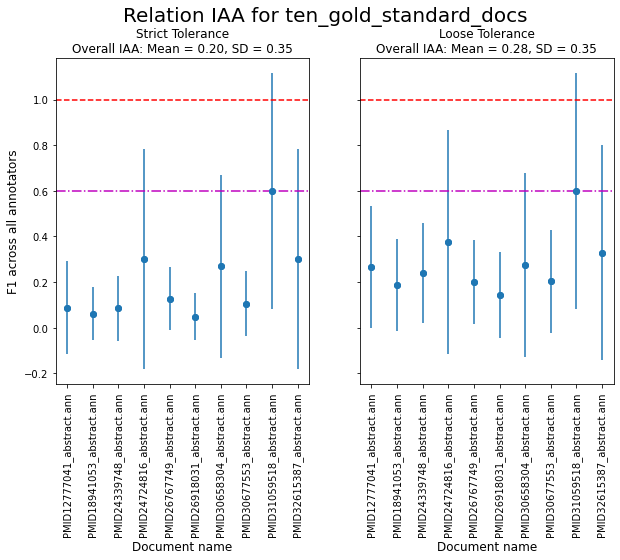

In [29]:
plot_relation_iaa(first_strict_per_doc, first_strict_overall, first_loose_per_doc, first_loose_overall, 'ten_gold_standard_docs')

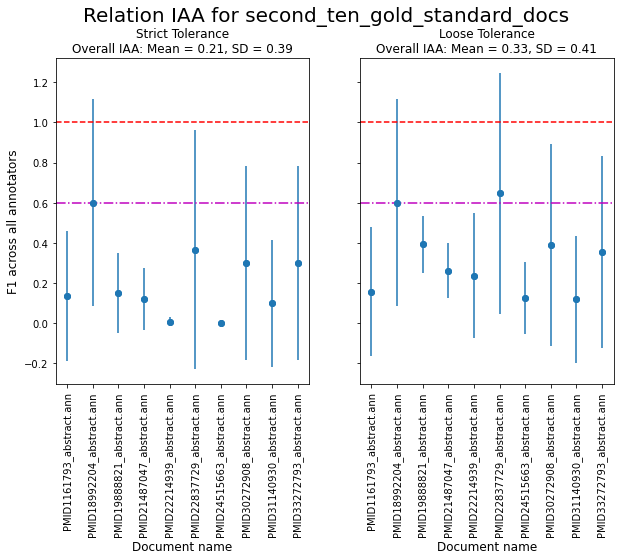

In [30]:
plot_relation_iaa(second_strict_per_doc, second_strict_overall, second_loose_per_doc, second_loose_overall, 'second_ten_gold_standard_docs')

## Overall IAA trends


Read the remaining data that's not already here:

In [31]:
_, third_ten_ent_overall = read_entity_iaa(f'{path}/third_ten_gold_standard_docs_entityIAA.md')
_, top_ten_journals_ent_overall = read_entity_iaa(f'{path}/top_ten_journals_entity_IAA.md')

Plots:

In [32]:
def plot_overall_iaa(overall_dict_ents, overall_dict_rels):
    """
    Plot overall IAA and their std. One subplot for entities, one for relations 
    
    parameters: 
        overall_dict_ents, dict: keys are name of dataset, values are a tuple of (mean, std)
        overall_dict_rels, dict: keys are name of dataset, values are a list of 2 tuples (mean, std) for the 
            strict and loose tolerances, respectively 
        
    returns: None 
    """
    # Define titles 
    title = f'IAA for Annotation Sets'
    plot_ent = 'Entities'
    plot_rel = 'Relations'
    
    # Make plot 
    fig, ax = plt.subplots(1, 2, figsize=(10, 6), sharey=True)
    
    plt.suptitle(f'{title}', fontsize=20, y=1)
    
    ax[0].scatter(x=list(overall_dict_ents.keys()), y=[val[0] for val in overall_dict_ents.values()])
    ax[0].errorbar(list(overall_dict_ents.keys()), [val[0] for val in overall_dict_ents.values()],
                   yerr=[val[1] for val in overall_dict_ents.values()], fmt="o")
    for tick in ax[0].get_xticklabels():
        tick.set_rotation(90)
    ax[0].set_title(plot_ent)
    ax[0].set_xlabel('Round name', fontsize=12)
    ax[0].set_ylabel('F1 across all annotators and all documents', fontsize=12)
    ax[0].axhline(y=1.0, color='r', linestyle='dashed')
    ax[0].axhline(y=0.6, color='m', linestyle='dashdot')
    print([val[0][0] for val in overall_dict_rels.values()])
    ax[1].scatter(x=list(overall_dict_rels.keys()), y=[val[0][0] for val in overall_dict_rels.values()], color='r')
    ax[1].errorbar(list(overall_dict_rels.keys()), [val[0][0] for val in overall_dict_rels.values()], 
                   yerr=[val[0][1] for val in overall_dict_rels.values()], fmt="o")
    ax[1].scatter(x=list(overall_dict_rels.keys()), y=[val[1][0] for val in overall_dict_rels.values()], color='b')
    ax[1].errorbar(list(overall_dict_rels.keys()), [val[1][0] for val in overall_dict_rels.values()], 
                   yerr=[val[1][1] for val in overall_dict_rels.values()], fmt="o") 
    for tick in ax[1].get_xticklabels():
        tick.set_rotation(90)
    ax[1].set_title(plot_rel)
    ax[1].set_xlabel('Round name', fontsize=12)
    ax[1].axhline(y=1.0, color='r', linestyle='dashed')
    ax[1].axhline(y=0.6, color='m', linestyle='dashdot')


Define dicts:


In [33]:
first_strict_overall.loc['mean'].values[0]

0.1984422288788186

In [34]:
ent_dict = {'ten_gold_standard_docs': first_ten_overalls['inst'],
           'second_ten_gold_standard_docs': second_ten_overalls['inst'],
           'third_ten_gold_standard_docs': third_ten_ent_overall['inst'],
           'top_ten_journal_abstracts': top_ten_journals_ent_overall['inst']}

rel_dict = {'ten_gold_standard_docs': [(first_strict_overall.loc['mean'].values[0], first_strict_overall.loc['std'].values[0]), 
                                       (first_loose_overall.loc['mean'].values[0], first_loose_overall.loc['std'].values[0])],
            'second_ten_gold_standard_docs': [(second_strict_overall.loc['mean'].values[0], second_strict_overall.loc['std'].values[0]), 
                                               (second_loose_overall.loc['mean'].values[0], second_loose_overall.loc['std'].values[0])]}


[0.1984422288788186, 0.208291306643092]


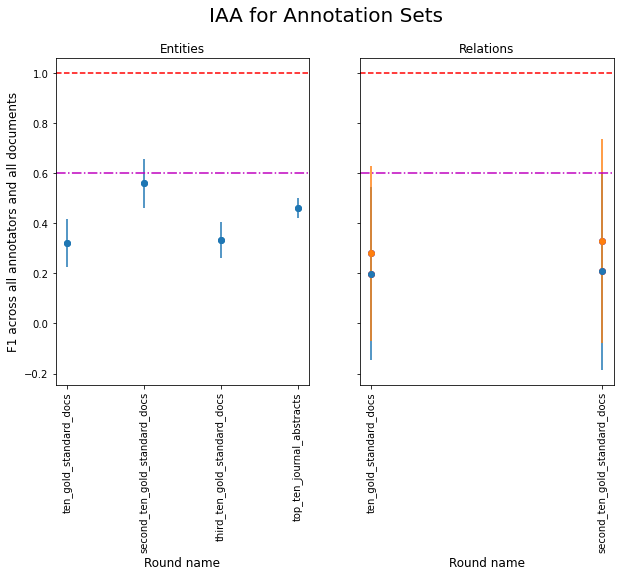

In [35]:
plot_overall_iaa(ent_dict, rel_dict)

## Overall IAA trend for entities only
For PRISMA poster

In [36]:
path = '../data/straying_off_topic_data/iaa/'
_, first_ten_overalls = read_entity_iaa('../data/straying_off_topic_data/iaa/ten_gold_standard_docs.md')
_, second_ten_overalls = read_entity_iaa('../data/straying_off_topic_data/iaa/second_ten_gold_standard_docs.md')
_, third_ten_ent_overall = read_entity_iaa(f'{path}/third_ten_gold_standard_docs_entityIAA.md')
_, top_ten_journals_ent_overall = read_entity_iaa(f'{path}/top_ten_journals_entity_IAA.md')
_, five_gold_overall = read_entity_iaa('/mnt/home/lotrecks/Shiu_lab/knowledge-graph/data/straying_off_topic_data/iaa/five_gold_standard_docs_entity_IAA.md')
_, last_ten_overall = read_entity_iaa('/mnt/home/lotrecks/Shiu_lab/knowledge-graph/data/straying_off_topic_data/iaa/last_ten_with_types.md')
_, five_without_types = read_entity_iaa('/mnt/home/lotrecks/Shiu_lab/knowledge-graph/data/straying_off_topic_data/iaa/five_gold_standard_docs_one_ent_type.md')
_, last_ten_without_types = read_entity_iaa('/mnt/home/lotrecks/Shiu_lab/knowledge-graph/data/straying_off_topic_data/iaa/last_ten_without_types.md')

In [37]:
ent_dict = {'Set 1': first_ten_overalls['inst'],
           'Set 2': second_ten_overalls['inst'],
           'Set 3': third_ten_ent_overall['inst'],
           'Set 4': top_ten_journals_ent_overall['inst'],
           'Set 5 (5 docs)': five_gold_overall['inst'],
           'Set 6': last_ten_overall['inst'],
           'Set 5 without types': five_without_types['inst'],
           'Set 6 without types':last_ten_without_types['inst']}

12 Apr 2022: Editing the below function to remove the title & shorten y axis label

In [38]:
def plot_overall_iaa_ent_only(overall_dict_ents):
    """
    Plot overall IAA and their std.
    
    parameters: 
        overall_dict_ents, dict: keys are name of dataset, values are a tuple of (mean, std)
        
    returns: None 
    """
    # Define titles 
    #title = f'IAA for Annotation Sets'
    plot_ent = 'Entities'
    
    # Make plot 
    plt.scatter(x=list(overall_dict_ents.keys()), y=[val[0] for val in overall_dict_ents.values()])
    plt.errorbar(list(overall_dict_ents.keys()), [val[0] for val in overall_dict_ents.values()],
                   yerr=[val[1] for val in overall_dict_ents.values()], fmt="o")
    plt.xticks(rotation=90)
    #plt.title(title, fontsize=20, pad=20)
    plt.xlabel('Set name', fontsize=14)
    plt.ylabel('F1 Agreement Score', fontsize=14)
    plt.axhline(y=1.0, color='r', linestyle='dashed')
    plt.axhline(y=0.6, color='m', linestyle='dashdot')
    

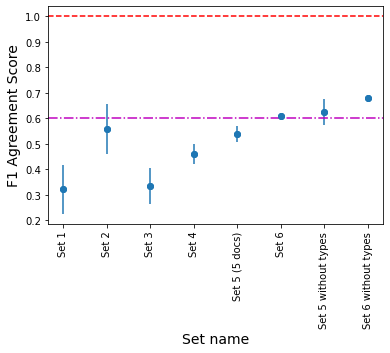

In [39]:
plot_overall_iaa_ent_only(ent_dict)
plt.savefig('../data/straying_off_topic_data/iaa/EAGER_Figure2A.png', dpi=1200, bbox_inches = "tight")

In Spanish:

In [40]:
ent_dict = {'Conjunto 1': first_ten_overalls['inst'],
           'Conjunto 2': second_ten_overalls['inst'],
           'Conjunto 3': third_ten_ent_overall['inst'],
           'Conjunto 4': top_ten_journals_ent_overall['inst'],
           'Conjunto 5 (5 docs)': five_gold_overall['inst'],
           'Conjunto 6': last_ten_overall['inst'],
           'Conjunto 5 sin clases': five_without_types['inst'],
           'Conjunto 6 sin clases':last_ten_without_types['inst']}

In [41]:
def plot_overall_iaa_ent_only(overall_dict_ents):
    """
    Plot overall IAA and their std.
    
    parameters: 
        overall_dict_ents, dict: keys are name of dataset, values are a tuple of (mean, std)
        
    returns: None 
    """
    # Define titles 
    title = r'Acuerdo entre annotaciones durante el desarrollo del guía'
    
    # Make plot 
    plt.scatter(x=list(overall_dict_ents.keys()), y=[val[0] for val in overall_dict_ents.values()])
    plt.errorbar(list(overall_dict_ents.keys()), [val[0] for val in overall_dict_ents.values()],
                   yerr=[val[1] for val in overall_dict_ents.values()], fmt="o")
    plt.xticks(rotation=90)
    plt.title(title, fontsize=16, pad=20)
    plt.xlabel('Conjunto', fontsize=14)
    plt.ylabel('F1', fontsize=14)
    plt.axhline(y=1.0, color='r', linestyle='dashed')
    plt.axhline(y=0.6, color='m', linestyle='dashdot')

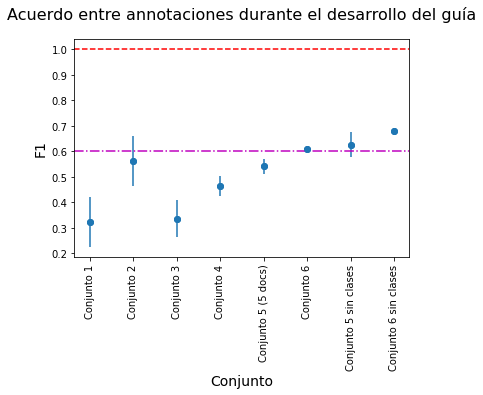

In [42]:
plot_overall_iaa_ent_only(ent_dict)

---------------------------------------------------------
## Figure for 1st chapter manuscript


### Get the mean single-blind IAA values

In [43]:
from os import listdir
from os.path import join, splitext

In [44]:
path = '../data/straying_off_topic_data/iaa/single_blind_entity_iaa/'
iaas = {}
for f in listdir(path):
    _, overall = read_entity_iaa(join(path, f))
    name = splitext(f)[0]
    iaas[name] = overall

In [45]:
iaas

{'kenia_set4': {'inst': (0.389, 0.0), 'tok': (0.446, 0.0)},
 'brianna_set1': {'inst': (0.22, 0.0), 'tok': (0.208, 0.0)},
 'melissa_set5': {'inst': (0.611, 0.0), 'tok': (0.66, 0.0)},
 'kenia_set6': {'inst': (0.658, 0.0), 'tok': (0.703, 0.0)},
 'brianna_set3': {'inst': (0.243, 0.0), 'tok': (0.254, 0.0)},
 'kenia_set1': {'inst': (0.143, 0.0), 'tok': (0.187, 0.0)},
 'brianna_set2': {'inst': (0.329, 0.0), 'tok': (0.357, 0.0)},
 'ally_set2': {'inst': (0.284, 0.0), 'tok': (0.326, 0.0)},
 'thilanka_set5': {'inst': (0.665, 0.0), 'tok': (0.738, 0.0)},
 'kenia_set2': {'inst': (0.334, 0.0), 'tok': (0.376, 0.0)},
 'abigail_set2': {'inst': (0.383, 0.0), 'tok': (0.423, 0.0)},
 'ally_set4': {'inst': (0.3, 0.0), 'tok': (0.345, 0.0)},
 'thilanka_set1': {'inst': (0.079, 0.0), 'tok': (0.092, 0.0)},
 'ally_set3': {'inst': (0.264, 0.0), 'tok': (0.258, 0.0)},
 'abigail_set1': {'inst': (0.162, 0.0), 'tok': (0.167, 0.0)},
 'kenia_set3': {'inst': (0.367, 0.0), 'tok': (0.382, 0.0)},
 'kenia_set5': {'inst': (0.57

In [46]:
set_vals = {}
for docset in ['set1', 'set2', 'set3', 'set4', 'set5', 'set6']:
    set_vals[docset] = [v['inst'][0] for k, v in iaas.items() if docset in k]

In [47]:
set_vals

{'set1': [0.22, 0.143, 0.079, 0.162],
 'set2': [0.329, 0.284, 0.334, 0.383],
 'set3': [0.243, 0.264, 0.367, 0.368],
 'set4': [0.389, 0.3, 0.3],
 'set5': [0.611, 0.665, 0.575],
 'set6': [0.658, 0.746]}

In [48]:
set_vals_means = {k:sum(v)/len(v) for k, v in set_vals.items()}

In [49]:
set_vals_means

{'set1': 0.151,
 'set2': 0.3325,
 'set3': 0.3105,
 'set4': 0.3296666666666667,
 'set5': 0.617,
 'set6': 0.702}

### Combine with the double-blind IAA values in one plot
Have to run all above cells to get the data

In [53]:
ent_dict

{'Conjunto 1': (0.322, 0.097),
 'Conjunto 2': (0.56, 0.098),
 'Conjunto 3': (0.335, 0.072),
 'Conjunto 4': (0.462, 0.039),
 'Conjunto 5 (5 docs)': (0.54, 0.031),
 'Conjunto 6': (0.61, 0.0),
 'Conjunto 5 sin clases': (0.626, 0.05),
 'Conjunto 6 sin clases': (0.678, 0.0)}

In [56]:
db_vals = [ent_dict[k][0] for k in ent_dict.keys()][:-2]
db_vals

[0.322, 0.56, 0.335, 0.462, 0.54, 0.61]

In [89]:
!pwd

/mnt/ufs18/home-118/lotrecks/Shiu_lab/knowledge-graph/jupyter_notebooks


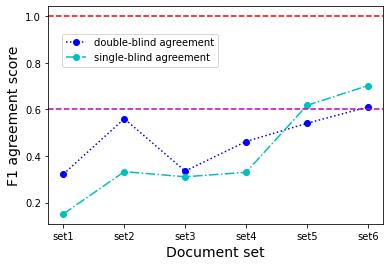

In [90]:
plt.plot(set_vals_means.keys(), db_vals,'bo:', label='double-blind agreement')
plt.plot(set_vals_means.keys(), set_vals_means.values(), 'co-.', label='single-blind agreement') 
plt.axhline(0.6, color='m', linestyle='dashed')
plt.axhline(1.0, color='r', linestyle='dashed')
plt.ylabel('F1 agreement score', fontsize=14)
plt.xlabel('Document set', fontsize=14)
plt.legend(bbox_to_anchor=[0.025,0.7])
plt.savefig('../data/straying_off_topic_data/iaa/single_double_blind_iaa.png')